In [80]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import random

import cv2
from skimage import io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from tqdm import tqdm

import SimpleITK as sitk
import pylab
%matplotlib inline 

TRAIN_PATH = '../data/stage1_train/'
TEST_PATH = '../data/stage1_test/'

In [2]:
# Utility function for plotting multiple images
def plots(imgs, figsize=(12,6), rows=1, title=None, titles=None):
    f = plt.figure(figsize=figsize)
    if title is not None: plt.title(title)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=8)
        plt.imshow(np.squeeze(imgs[i]), cmap='gray')

In [87]:
# need to install SimpleITK
# https://itk.org/Doxygen/html/classitk_1_1BinaryContourImageFilter.html#a0e8485c516ceefbb4408198cc302f869
# part of the contour miss
def get_contour(img_arr):
    idx = img_arr > 128
    img_arr[idx] = 255
    idx = img_arr < 128
    img_arr[idx] = 0
    img = sitk.GetImageFromArray(img_arr)
    binaryContourFilter = sitk.BinaryContourImageFilter()
    binaryContourFilter.SetForegroundValue(255)
    binaryContourFilter.SetBackgroundValue(0)
    binaryContourFilter.SetFullyConnected(True)
    img_contour = binaryContourFilter.Execute(img)
    return sitk.GetArrayFromImage(img_contour)



In [88]:
# need to install SimpleITK
def get_gradient(img_arr):
    img = sitk.GetImageFromArray(img_arr)
    
    gradFilter = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradFilter.SetSigma(1.0)
    img_gradient = gradFilter.Execute(img)
    
    rescaleFilter = sitk.RescaleIntensityImageFilter()
    rescaleFilter.SetOutputMinimum(0)
    rescaleFilter.SetOutputMaximum(255)
    img_gradient = rescaleFilter.Execute(img_gradient)
    return sitk.GetArrayFromImage(img_gradient)

In [104]:
# Reading and pre-processing mainly based on:
# https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352
def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
#     print(filepath)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img

def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
#         contour_tmp = get_contour(mask_tmp)
        contour_tmp = get_gradient(mask_tmp)
        if not i: 
            mask = mask_tmp
            contour = contour_tmp
        else: 
            mask = np.maximum(mask, mask_tmp)
            contour = np.maximum(contour, contour_tmp)
    return mask, contour

def load_raw_data(image_size=(256, 256)):
    save_name = '../data/dataset_{}x{}'.format(image_size[0],image_size[1])
    save_path = save_name + '.npz'
    
    if os.path.isfile(save_path):
        print('Reading from previously loaded data.')
        npzfile = np.load(save_path)
        return npzfile['X_train'], npzfile['Y_train'], npzfile['C_train'], npzfile['X_test']
    
    train_ids = next(os.walk(TRAIN_PATH))[1]
    test_ids = next(os.walk(TEST_PATH))[1]
    
    print('Getting and resizing train images and masks ... ')
    # TODO do we need dtype for these images?
    X_train = np.zeros((len(train_ids), image_size[0], image_size[1], 3), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), image_size[1], image_size[1]))
    C_train = np.zeros((len(train_ids), image_size[1], image_size[1]))
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = read_image(path + '/images/' + id_ + '.png', target_size=image_size)
        mask, contour = read_mask(path + '/masks/', target_size=image_size)
        X_train[n] = img
        Y_train[n] = mask
        C_train[n] = contour
#         plots([img, mask, contour])

    Y_train = np.expand_dims(Y_train, axis=4)
    C_train = np.expand_dims(C_train, axis=4)
        
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    X_test = np.zeros((len(test_ids), image_size[0], image_size[1], 3), dtype=np.uint8)
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = read_image(path + '/images/' + id_ + '.png', target_size=image_size)
        X_test[n] = img

    print('Saving to npz...')
    np.savez_compressed(save_name, X_train=X_train, Y_train=Y_train, C_train=C_train, X_test=X_test)
    print('Done!')
    return X_train, Y_train, C_train, X_test

In [105]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

X_train, Y_train, C_train, X_test = load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH))

Reading from previously loaded data.


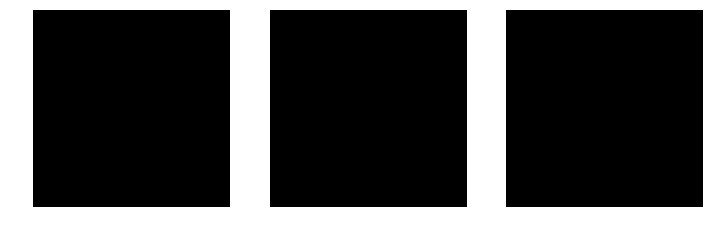

In [100]:
idx = random.randint(1, X_train.shape[0])
plots([X_train[idx], Y_train[idx], C_train[idx]])

In [ ]:
def preprocess_raw_data(x_train, y_train, x_test, grayscale=False, invert=False):
    pass